# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cpu
device_count:  0
Torch version:  2.8.0+cu126
torch.version.cuda:  12.6
Is CUDA enabled? False


# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

# Fcn

In [ ]:
# see paper GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2
vlsr_sun = 15.17 # km/s


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 500)

# Define the Gaussian function
def gaussian(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

In [ ]:
def binned_median(x: np.ndarray, y: np.ndarray, bin_edges: np.ndarray, n_resamples = 1000):
    from scipy import stats

    # Calculate the bin average using scipy
    bin_avg, _, _ = stats.binned_statistic(x, y, statistic='median', bins=bin_edges)

    # Container for bin averages
    bin_avg_arr = []

    # Perform bootstrap resampling and calculate bin averages
    for _ in range(n_resamples):
        resample_indices = np.random.choice(len(y), size=len(y), replace=True)
        resample_y= y[resample_indices]
        bin_avg_resample, _, _ = stats.binned_statistic(x, resample_y, statistic='median', bins=bin_edges)
        bin_avg_arr.append(bin_avg_resample)

    # Compute the upper and lower percentiles of the bin averages
    bin_avg_arr = np.array(bin_avg_arr)
    bin_mean_arr = np.mean(bin_avg_arr, axis=0)
    bin_avg_upper = np.percentile(bin_avg_arr, 97.5, axis=0) - bin_mean_arr + bin_avg
    bin_avg_lower = np.percentile(bin_avg_arr, 2.5, axis=0) - bin_mean_arr + bin_avg

    return bin_avg, bin_avg_upper, bin_avg_lower

In [ ]:
# Define the Gaussian function with FWHM
def gaussian(x, A, x0, FWHM):
    sigma = FWHM / 2.3548
    return A * np.exp(-(x-x0)**2 / (2*sigma**2))

In [ ]:
def compute_column_density_KI(W_lambda_angstrom):
    """
    Compute the column density for weak lines:

    \[
    W_{\lambda} = \frac{\pi e^2}{m_e c^2} f \lambda^2 N
    \]

    Where:

    - \( e \) is the electron charge
    - \( m_e \) is the electron mass
    - \( c \) is the speed of light
    - \( f \) is the oscillator strength of the transition
    - \( \lambda \) is the wavelength of the line

    """
    # f = 0.3393  # Oscillator strength
    f = 0.332 # Oscillator strength
    lambda_ = 7698.9643 * u.Angstrom  # Wavelength in Angstrom lambda_rest = 7698.9643 # Angstroms

    # Convert equivalent width from Angstrom to meters
    W_lambda_m = (W_lambda_angstrom * u.Angstrom).to(u.m)

    # Compute column density using the formula
    N = (W_lambda_m * const.m_e * const.c**2) / (np.pi * const.e.gauss**2 * f * lambda_.to(u.m)**2)

    return N.to(10**(10)/u.cm**2)  # This ensures the column density is returned in SI units (m^-2)

In [ ]:
def mollweide_histogram(ra, dec, distance, eq_width, bin_size=1000, nside=32):
    """
    Plots a histogram in Mollweide projection using HEALPix binning that shows the median
    equivalent width for bins of distances, in galactic coordinates.

    Parameters:
    - ra (array): Right ascension in degrees.
    - dec (array): Declination in degrees.
    - distance (array): Distance in parsec.
    - eq_width (array): Equivalent width in Å.
    - bin_size (int, optional): The size of the distance bins. Default is 200 parsecs.
    - nside (int, optional): The resolution of the HEALPix map. Default is 32.
    """
    # Convert equatorial coordinates (RA, Dec) to galactic coordinates (l, b)
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    l = c.galactic.l.degree
    b = c.galactic.b.degree

    # Convert (l, b) to HEALPix indices
    indices = hp.ang2pix(nside, l, b, lonlat=True)

    # Get maximum distance for binning
    max_dist = np.max(distance)

    # Create bins for distances
    bins = np.arange(0, max_dist + bin_size, bin_size)

    for i in range(len(bins) - 1)[:2]:
        mask = (distance >= 0) & (distance < bins[i+1])
        if np.any(mask):
            median_map = np.full(hp.nside2npix(nside), np.nan)
            for ind in np.unique(indices[mask]):
                median_map[ind] = np.median(eq_width[(indices == ind) & mask])

            hp.mollview(
                median_map,
                title=f'N(KI) 7699',
                cmap='plasma',
                min=7,max=21,
                badcolor='None',
                bgcolor='None',
                unit = r'N(KI) 7699 / $10^{10}\,\mathrm{cm^{-2}}$'
            )
            hp.graticule()

            plt.savefig('figures/n_k_'+str(i)+'.png',dpi=200,bbox_inches='tight', transparent=True)
            plt.show()
            plt.close()

# For plotting

In [ ]:

# Circle
def _circle(x, y, r):
    theta = np.linspace(0, 2*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_LMC = 279.
gb_LMC = -33.5
R_LMC = 5.

gl_SMC = 302.
gb_SMC = -44.5
R_SMC = 3.

LMC = dict(
    gl = gl_LMC,
    gb = gb_LMC,
    center = [gl_LMC, gb_LMC],
    glon_range = [270., 307.],
    glat_range = [-48., -25.],
    circ = _circle(gl_LMC, gb_LMC, R_LMC),
    name = 'Large Magellanic Cloud'
)


SMC = dict(
    gl = gl_SMC,
    gb = gb_SMC,
    center = [gl_SMC, gb_SMC],
    glon_range = [295., 315.],
    glat_range = [-50., -40.],
    circ = _circle(gl_SMC, gb_SMC, R_SMC),
    name = 'Small Magellanic Cloud'
)


# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = SMC['circ']
LMC_xcirc, LMC_ycirc = LMC['circ']

# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of all sources 2714


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
galah0 = Table.read(allstar_file)
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
med_dist_lim = 30_000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
# See Section 8.9, Bug of interstellar K velocity in Buder et al. (2025)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection','ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

In [ ]:
med_dist = np.array(galah['r_med'].data, dtype='float32')

field_ids = np.array(galah['field_id'].data, dtype='int16')
star_ids = np.array(galah['sobject_id'].data, dtype='int64')

ra = galah['ra'].data
dec = galah['dec'].data

ew_k_is = galah['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))
rv_k_is = galah['rv_k_is']

ebv = galah['ebv']

glon = galah['l'].data
glat = galah['b'].data

# HI maps

In [ ]:
# Moment Maps
tb_file = data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
tb_peak_map, tb_hdr = fits.getdata(tb_file, header=True)
print(tb_peak_map.shape)

tb_w = WCS(tb_hdr)
print(tb_w)

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999963 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


# Read csv: GALAH stars with 3sigma KI detections

In [ ]:
galah_fg_df_csv_file = data_path / 'galah_fg_df_3sigma_v2.csv'
galah_fg_df = pd.read_csv(galah_fg_df_csv_file)
galah_fg_df

In [ ]:
galah_fg_df.yn.value_counts()

,count
yn,
True,14005
False,388


In [ ]:
galah_fg_df = galah_fg_df[(galah_fg_df.yn == True) & (galah_fg_df.ew_k_is < 0.1) & (galah_fg_df.r_med > 300.) & (galah_fg_df.age > 0.1) & (galah_fg_df.ebv < 1.)]
galah_fg_df = galah_fg_df[~galah_fg_df['field_id'].isin([-1, 180, 7365, 7364, 7363, 177, 411, 339, 321, 245, 344, 7122, 7156, 7128, 1056, 7120, 1092, 7182, 291, 129, 7211, 7210, 7212, 7213, 211, 7157,  7139, 7141, 7142, 1162, 7143, 7129, 7129, 7075, 251, 182, 7075, 7074, 70, 95, 141, 233, 7140, 7127, 7121, 7132])]
galah_fg_df

In [ ]:
field_ids = galah_fg_df['field_id'].values
glon_fg = galah_fg_df['l'].values
glat_fg = galah_fg_df['b'].values

# Select stars within the GASKAP footbprint

In [ ]:
from shapely.geometry import Point, Polygon

In [ ]:
gl_boundary = np.array([296.9,  300., 302.4,  305.,  304.9, 306., 307.3, 307.4, 305.4,  303., 298.,  297.6,  299., 297.4, 295.8,  295.,  291.5,  293.3, 292.3,  286., 284.9, 283.9, 272.0, 271., 286.5,  288.5, 289.5, 293.6, 295.1, 296.9])
gb_boundary = np.array([-36.5, -35.4, -35.6, -40.3, -41.2, -41.3, -42.3, -43.5, -47.5, -48.0, -46.0, -44.8, -42.9, -42.0, -38.40, -38.25, -39.2, -43.5, -44.6, -45.2, -44.5, -40.4, -41.3, -29.4, -27.8, -28.1, -32.5, -31.6, -31.9, -36.5])

print(len(gb_boundary))

polygon = Polygon(list(zip(gl_boundary, gb_boundary)))
polygon

In [ ]:
star_points = [Point(coord[0], coord[1]) for coord in list(zip(glon_fg, glat_fg))]
print(len(star_points))

10499


In [ ]:
# Check if the point is within the polygon
is_inside = polygon.contains(star_points)
is_inside

array([False, False, False, ..., False, False, False])

In [ ]:
galah_fg_df['in_footprint'] = False
galah_fg_df['in_footprint'] = is_inside

In [ ]:
galah_fg_df = galah_fg_df[galah_fg_df['in_footprint'] == True]
galah_fg_df

In [ ]:
field_ids = galah_fg_df['field_id'].values
glon_fg = galah_fg_df['l'].values
glat_fg = galah_fg_df['b'].values

In [ ]:
# Get unique field IDs
unique_field_ids = np.unique(field_ids)

# Compute means for each field_id
field_lb_means = []
for field_id in unique_field_ids:
    mask = (field_ids == field_id)  # Mask rows with the current field_id
    glon_mean = np.mean(glon_fg[mask])
    glat_mean = np.mean(glat_fg[mask])
    field_lb_means.append((field_id, glon_mean, glat_mean))

# Print results
for field_id, glon_mean, glat_mean in field_lb_means:
    print(f"Field ID: {field_id}, Mean Glon: {glon_mean:.2f}, Mean Glat: {glat_mean:.2f}")

In [ ]:
ebv_ism_fg = galah_fg_df['ebv'].values
ew_ki_ism_fg = galah_fg_df['ew_k_is'].values
n_ki_ism_fg = np.array(compute_column_density_KI(ew_ki_ism_fg))

# Plot: LOS/Sources on NHI maps

In [ ]:
# NHI Map
gaskap_nhi_file = gaskap_data_path / 'nhi_thin_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
gaskap_nhi, gaskap_nhi_hdr = fits.getdata(gaskap_nhi_file, header=True)
print(gaskap_nhi.shape)

gaskap_nhi_w = WCS(gaskap_nhi_hdr)
print(gaskap_nhi_w)


gaskap_nhi[gaskap_nhi < 0.] = 0.

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999962 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


In [ ]:
galah_gl_coords = SkyCoord(glon_fg, glat_fg, frame='galactic', unit='deg')
print(galah_gl_coords)

<SkyCoord (Galactic): (l, b) in deg
    [(307.33833223, -43.02568216), (307.05440437, -42.27173884),
     (307.37768948, -43.44185215), ..., (286.25580239, -27.89819627),
     (285.95614173, -27.88716795), (286.33041094, -27.8459304 )]>


In [ ]:
galah_x, galah_y = galah_gl_coords.to_pixel(wcs=gaskap_nhi_w)
galah_x

array([ 358.49744728,  365.9011757 ,  368.1337588 , ..., 2743.92953736,
       2784.42129954, 2733.97861841])

In [ ]:
galah_x = np.round(galah_x).astype(int)
galah_y = np.round(galah_y).astype(int)
print(galah_x)
print(galah_y)

print(galah_x[0])
print(galah_y[0])

[ 358  366  368 ... 2744 2784 2734]
[ 839  962  775 ... 3388 3389 3396]
358
839


In [ ]:
gaskap_nhi_thin = np.zeros_like(ew_ki_ism_fg)
for jj, (galah_xi, galah_yi) in enumerate(zip(galah_x, galah_y)):
    gaskap_nhi_thin[jj] = gaskap_nhi[galah_yi, galah_xi]

In [ ]:
import scipy
print('nhi vs ew: pearson coefficient', scipy.stats.pearsonr(gaskap_nhi_thin, ew_ki_ism_fg))    # Pearson's r
print('nhi vs ew: spearman coefficient', scipy.stats.spearmanr(gaskap_nhi_thin, ew_ki_ism_fg))    # spearmanr's r

nhi vs ew: pearson coefficient PearsonRResult(statistic=np.float64(0.29184776298658116), pvalue=np.float64(4.070714151675873e-192))
nhi vs ew: spearman coefficient SignificanceResult(statistic=np.float64(0.3595965746218656), pvalue=np.float64(1.2038337615286835e-297))


In [ ]:
sel_idx = np.where((gaskap_nhi_thin > 0.) & (gaskap_nhi_thin < 14.))[0]
len(sel_idx)

9821

In [ ]:
statpr, statpp = scipy.stats.pearsonr(ebv_ism_fg, n_ki_ism_fg)
statspr, statspp = scipy.stats.spearmanr(ebv_ism_fg, n_ki_ism_fg)
print('tbpeak vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('tbpeak vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

tbpeak vs nki: pearson coefficient, statistic = 0.07642251144491849 , p-value = 3.349106569980857e-14
tbpeak vs nki: spearman coefficient, statistic = 0.3042775578761515 , p-value = 1.7774600950757383e-209


In [ ]:
statpr, statpp = scipy.stats.pearsonr(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx])
statspr, statspp = scipy.stats.spearmanr(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx])
print('nhi vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi vs nki: pearson coefficient, statistic = 0.2919219524136203 , p-value = 3.372642210451496e-192
nhi vs nki: spearman coefficient, statistic = 0.35969358089835995 , p-value = 8.702910494760537e-298


In [ ]:
ki_hi_ratio = n_ki_ism_fg[sel_idx] / gaskap_nhi_thin[sel_idx]
ki_hi_ratio

array([8.82471074, 4.08255212, 5.49250112, ..., 1.88457273, 1.61056326,
       1.12745484])

In [ ]:
idx = np.where((ki_hi_ratio > 0.) & (ki_hi_ratio < 50.))
ki_hi_ratio_ok = ki_hi_ratio[idx]
gaskap_nhi_thin_ok = gaskap_nhi_thin[idx]

# Tb peak

In [ ]:
galah_gl_coords = SkyCoord(glon_fg, glat_fg, frame='galactic', unit='deg')
print(galah_gl_coords)

<SkyCoord (Galactic): (l, b) in deg
    [(307.33833223, -43.02568216), (307.05440437, -42.27173884),
     (307.37768948, -43.44185215), ..., (286.25580239, -27.89819627),
     (285.95614173, -27.88716795), (286.33041094, -27.8459304 )]>


In [ ]:
galah_x, galah_y = galah_gl_coords.to_pixel(wcs=tb_w)
galah_x

array([ 358.49744728,  365.9011757 ,  368.1337588 , ..., 2743.92953736,
       2784.42129954, 2733.97861841])

In [ ]:
galah_x = np.round(galah_x).astype(int)
galah_y = np.round(galah_y).astype(int)
print(galah_x)
print(galah_y)

print(galah_x[0])
print(galah_y[0])

[ 358  366  368 ... 2744 2784 2734]
[ 839  962  775 ... 3388 3389 3396]
358
839


In [ ]:
# This method also works with arrays of world coordinates
glon_array = np.array([300.0, 290.0, 280.0])
glat_array = np.array([-45.0, -37., -45.0])

pixel_x_array, pixel_y_array = tb_w.wcs_world2pix(glon_array, glat_array, 0)

print(f"\nArray of world coordinates (GLON, GLAT):\n{np.vstack((glon_array, glat_array)).T}")
print(f"Corresponding array of pixel coordinates (x, y):\n{np.vstack((pixel_x_array, pixel_y_array)).T}")

pixel_x_array = np.round(pixel_x_array).astype(int)
pixel_y_array = np.round(pixel_y_array).astype(int)
print(pixel_x_array)
print(pixel_y_array)


Array of world coordinates (GLON, GLAT):
[[300. -45.]
 [290. -37.]
 [280. -45.]]
Corresponding array of pixel coordinates (x, y):
[[1229.70501384  699.04153707]
 [2273.28467214 2000.74277566]
 [3372.32181317  760.75563911]]
[1230 2273 3372]
[ 699 2001  761]


In [ ]:
gaskap_tb_peak_arr = np.zeros_like(ew_ki_ism_fg)
for jj, (galah_xi, galah_yi) in enumerate(zip(galah_x, galah_y)):
    gaskap_tb_peak_arr[jj] = tb_peak_map[galah_yi, galah_xi]

In [ ]:
sel_idx = np.where((gaskap_nhi_thin > 0.) & (gaskap_nhi_thin < 14.) & (gaskap_tb_peak_arr < 60.))[0]
len(sel_idx)

9821

In [ ]:
statpr, statpp = scipy.stats.pearsonr(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx])
statspr, statspp = scipy.stats.spearmanr(gaskap_nhi_thin[sel_idx], n_ki_ism_fg[sel_idx])
print('nhi vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi vs nki: pearson coefficient, statistic = 0.2919219524136203 , p-value = 3.372642210451496e-192
nhi vs nki: spearman coefficient, statistic = 0.35969358089835995 , p-value = 8.702910494760537e-298


In [ ]:
statpr, statpp = scipy.stats.pearsonr(gaskap_tb_peak_arr[sel_idx], n_ki_ism_fg[sel_idx])
statspr, statspp = scipy.stats.spearmanr(gaskap_tb_peak_arr[sel_idx], n_ki_ism_fg[sel_idx])
print('tbpeak vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('tbpeak vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

tbpeak vs nki: pearson coefficient, statistic = 0.27675210129831546 , p-value = 3.663925742837823e-172
tbpeak vs nki: spearman coefficient, statistic = 0.33088671187781593 , p-value = 1.4030983107908952e-249


In [ ]:
ki_hi_ratio = n_ki_ism_fg[sel_idx] / gaskap_nhi_thin[sel_idx]

stats_series = pd.DataFrame(ki_hi_ratio).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,9821.000000
mean,2.781584
std,2.137411
min,0.261941
25%,1.521582
50%,2.190110
75%,3.306702
max,41.131644


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 2)
x_minval = round(series_values[3], 4)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

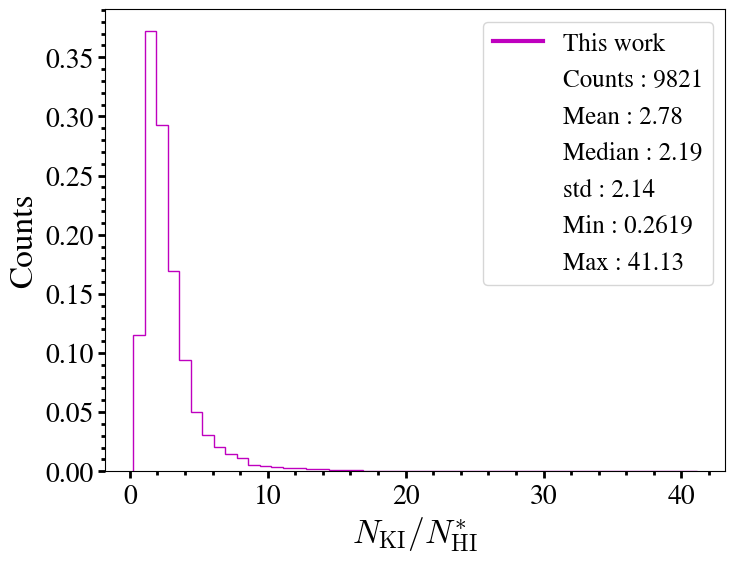

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(ki_hi_ratio, bins=np.linspace(np.nanmin(ki_hi_ratio), np.nanmax(ki_hi_ratio), 50),
         density=True, color='m', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'm-', lw=3, label=f'This work')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'$N_\mathrm{KI} / N^{*}_\mathrm{HI}$', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

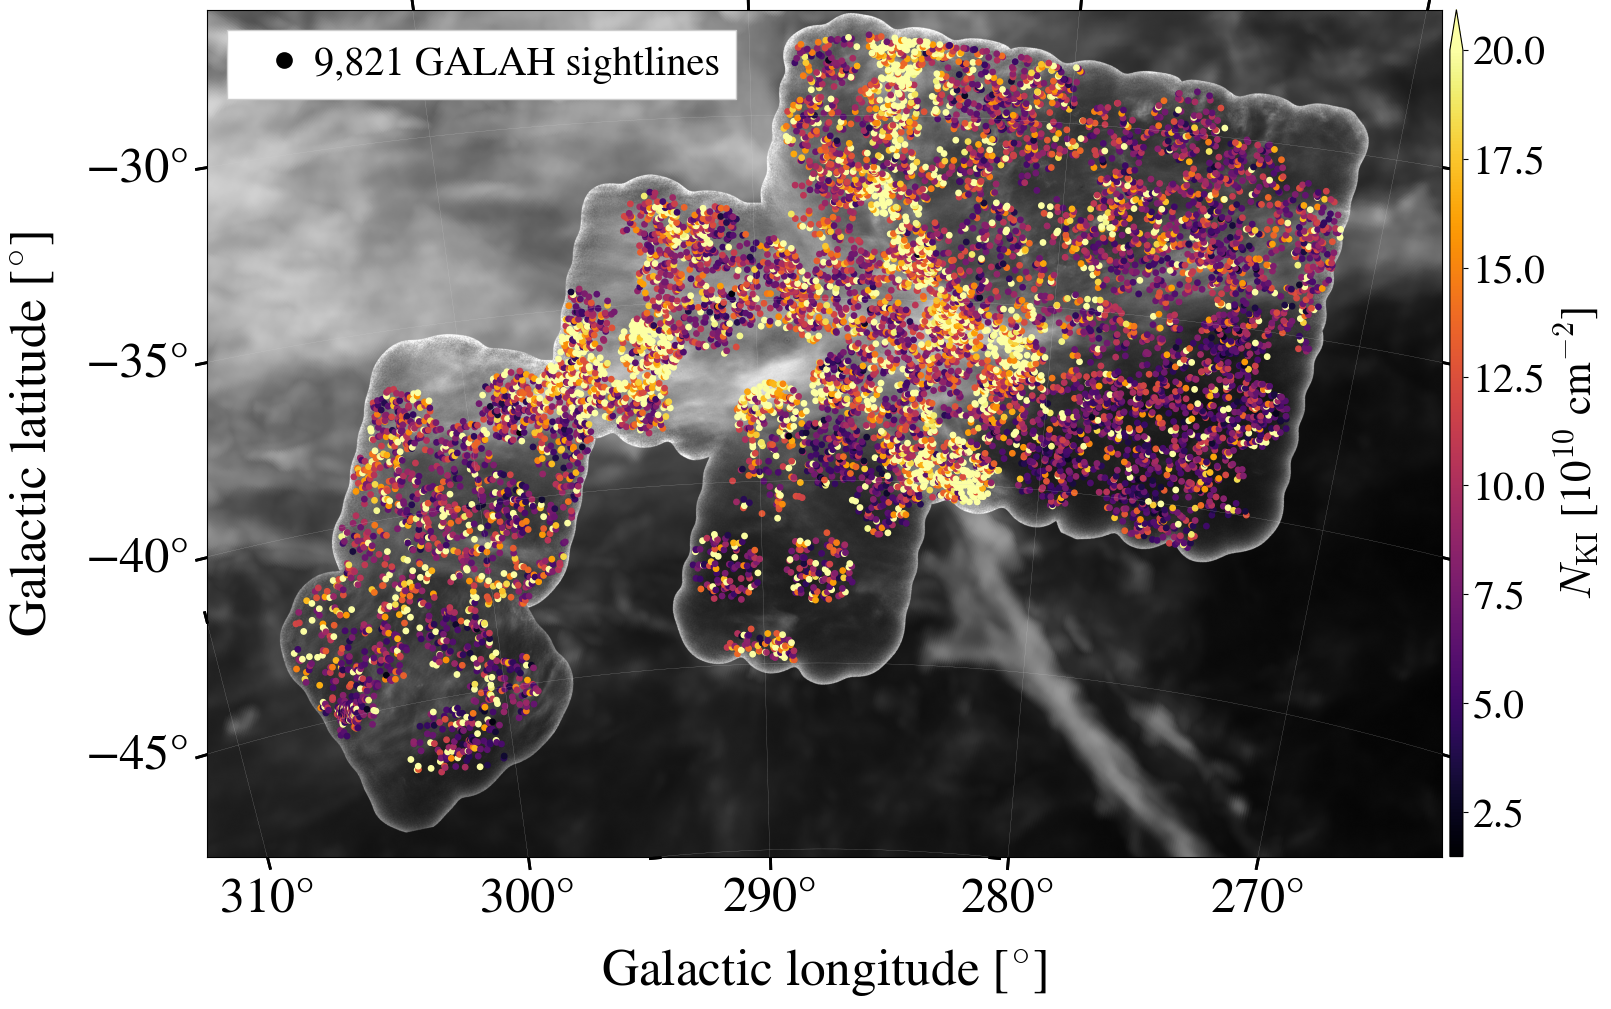

In [ ]:
xlbs = 37
tlbs = 36

cm = mpl.colormaps['inferno']


# Plot
fig = plt.figure(figsize=(18, 11))
ax = fig.add_subplot(111, projection=tb_w)

# Display the moment map image
im = ax.imshow(tb_peak_map, cmap='gray', vmin=0., vmax=60.)

sct = ax.scatter(glon_fg[sel_idx], glat_fg[sel_idx], s=15, c=n_ki_ism_fg[sel_idx], transform=ax.get_transform('galactic'),
           marker='o', cmap=cm, vmin=n_ki_ism_fg[sel_idx].min(), vmax=20.,
           label='')

ploti, = ax.plot([200], [3200], c='k', marker='o', markersize=9, mew=3, ls='', lw=0, label= "{:,} GALAH sightlines".format(len(glon_fg[sel_idx])))
ploti.set_visible(True)


# Add axes labels
ax.set_xlabel(r'Galactic longitude [$^{\circ}$]', fontsize=xlbs)
ax.set_ylabel(r'Galactic latitude [$^{\circ}$]', fontsize=xlbs)


# Color bar
cbar = fig.colorbar(sct, ax=ax, extend='max', orientation='vertical', fraction=0.01, pad=0.006, aspect=65)
cbar.ax.set_ylabel(r'$N_\mathrm{KI}$ [10$^{10}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=31)
cbar.ax.tick_params(labelsize=30)


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=2)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2, direction='out')
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=5)

ax.set_ylim(0, 3500)

ax.legend(loc='upper left', fancybox=False, framealpha=1., labelcolor='k', facecolor='w', handletextpad=-0.25, fontsize=29)

ax.grid(True, linestyle='--', linewidth=0.15, color='lightgray', zorder=-10)
plt.show()

# For matched lines of sight

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_using_gaussfit_smaller_radii_0155.csv'
print(gaskap_galah_csv_file)

ggdf = pd.read_csv(gaskap_galah_csv_file)
print(ggdf.shape)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/gaskap_abs_galah_star_ki_ism_using_gaussfit_smaller_radii_0155.csv
(462, 21)


In [ ]:
current_ggdf = ggdf[ggdf['star_id'] > 0]

In [ ]:
print(100.*current_ggdf.shape[0]/ggdf.shape[0])

62.77056277056277


In [ ]:
current_ggdf1 = current_ggdf.merge(df_det, left_on='src_name', right_on='comp_name', how='left')
current_ggdf1

In [ ]:
# Merge the dataframes
merged_df = current_ggdf1.merge(galah_df, left_on='star_id', right_on='sobject_id', how='left')
merged_df

In [ ]:
merged_df['nki'] = compute_column_density_KI(merged_df['ew_ki_ism'].values)

In [ ]:
table1_df = merged_df[['src_name', 'src_glon', 'src_glat', 'flux_int', 'star_id', 'r_med', 'l', 'b', 'nhi_x', 'nhi_y', 'nki', 'ki_ism_vlsr_obs', 'emt_min_vlsr', 'vlsr_hi_ki_diff']]
table1_df

In [ ]:
matching_srcs = merged_df.src_name.values
matching_src_glons = merged_df.src_glon.values
matching_src_glats = merged_df.src_glat.values

matching_star_glons = merged_df.l.values
matching_star_glats = merged_df.b.values

matching_star_distances = merged_df.r_med.values

In [ ]:
ki_hi_nsrcs = len(matching_srcs)
print(ki_hi_nsrcs)

290


In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_matched_los_smaller_radii_0155_extra_cols.csv'
print(gaskap_galah_csv_file)
# current_ggdf.to_csv(gaskap_galah_csv_file, index=False)

current_ggdf = pd.read_csv(gaskap_galah_csv_file)
current_ggdf

In [ ]:
peak_taus = current_ggdf['peak_tau'].values
peak_fit_taus = current_ggdf['peak_fit_tau'].values
peak_tbs = current_ggdf['peak_tb'].values
peak_close_tbs = current_ggdf['peak_close_tb'].values

nhi_tots = current_ggdf['nhi_tot'].values
nhi_thins = current_ggdf['nhi_thin'].values

ew_ki_ism = current_ggdf.ew_ki_ism.values

In [ ]:
N_ki_is = compute_column_density_KI(ew_ki_ism).value

# KI column density

In [ ]:
# Table 1, here https://articles.adsabs.harvard.edu/pdf/1974ApJ...188L..67H
ew_ki_hobbs = np.array([108., 93., 111., 79., 65., 100., 7., 45., 2.3, 4., 8., 38., 51., 79., 39., 11., 142.]) # mili-Angstrom
N_ki_hobbs = np.array([7., 5.9, 10., 7.6, 4.3, 7.5, 0.44, 3.0, 0.14, 0.25, 0.47, 2.5, 3.4, 6.9, 2.5, 0.63, 11.]) # 10^11 cm-2

N_ki_hobbs_10los = np.array([10., 7.6, 4.3, 0.44, 3.0, 0.14,  0.25, 2.5, 3.4, 6.9]) # 10^11 cm-2
N_hi_hobbs_10los = np.array([10., 12., 20.,  6.,  11.0, 1.75, 1.75, 12.5, 20., 5.])  # 10^20 cm-2




gamma = 6.e-11  # s-1
alpha = 5.6e-12 # cm3 s-1
ne    = 0.06    # cm-3

In [ ]:
N_hobbs_ratio = (N_ki_hobbs_10los/ N_hi_hobbs_10los)
print('Mean, Median:', np.mean(N_hobbs_ratio), np.median(N_hobbs_ratio)) # ~0.5 e-9

Mean, Median: 0.41672510822510817 0.20750000000000002


In [ ]:
N_gg_ratio = N_ki_is/10. / nhi_thins
print('Mean, Median:', np.mean(N_gg_ratio), np.median(N_gg_ratio)) # ~0.5 e-9 Hobbs 1974

Mean, Median: 0.3016988346095758 0.24061315593522983


In [ ]:
N_gg_ratio = N_ki_is/10. / nhi_tots
print('Mean, Median:', np.mean(N_gg_ratio), np.median(N_gg_ratio)) # ~0.5 e-9 Hobbs 1974

Mean, Median: 0.2777675401453294 0.22871112830323242


In [ ]:
ki_abund_ratio_hobbs = 10.*N_ki_hobbs_10los / N_hi_hobbs_10los # in unit of 10^-10
np.mean(ki_abund_ratio_hobbs)

np.float64(4.167251082251083)

In [ ]:
xv = nhi_tots
xv_lab = r'$N_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]'
yv = N_ki_is
yv_lab = r'$N_\mathrm{KI}$ [10$^{10}$ cm$^{-2}$]'

# Calculate Pearson correlation coefficient
pearson_corr, p_value = stats.pearsonr(xv, yv)

In [ ]:
print(f"Pearson correlation coefficient: {pearson_corr}")
print(f"p-value: {p_value}")

Pearson correlation coefficient: 0.3552863133109447
p-value: 4.707365230094881e-10


In [ ]:
statpr, statpp = stats.pearsonr(xv, yv)
statspr, statspp = stats.spearmanr(xv, yv)
print('nhi vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi vs nki: pearson coefficient, statistic = 0.3552863133109447 , p-value = 4.707365230094881e-10
nhi vs nki: spearman coefficient, statistic = 0.42543586768506053 , p-value = 3.5457846766988945e-14


In [ ]:
statpr, statpp = stats.pearsonr(N_ki_hobbs_10los, N_hi_hobbs_10los)
statspr, statspp = stats.spearmanr(N_ki_hobbs_10los, N_hi_hobbs_10los)
print('nhi vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi vs nki: pearson coefficient, statistic = 0.3106228948215168 , p-value = 0.3823655666941808
nhi vs nki: spearman coefficient, statistic = 0.4451302263229461 , p-value = 0.1973570541531603


In [ ]:
ki_abund_ratio_gg = yv/xv
print('GAGA mean: ', np.mean(ki_abund_ratio_gg))
print('GAGA median: ', np.median(ki_abund_ratio_gg))

GAGA mean:  2.777675401453294
GAGA median:  2.287111283032324


In [ ]:
ki_abund_ratio_hobbs = 10.*N_ki_hobbs_10los / N_hi_hobbs_10los # in unit of 10^-10
print('Hobbs 1974 mean: ', np.mean(ki_abund_ratio_hobbs))
print('Hobbs 1974 median: ', np.median(ki_abund_ratio_hobbs))

Hobbs 1974 mean:  4.167251082251083
Hobbs 1974 median:  2.075


In [ ]:
statpr, statpp = stats.pearsonr(ki_abund_ratio_gg, xv)
statspr, statspp = stats.spearmanr(ki_abund_ratio_gg, xv)
print('ratio vs nhi: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('ratio vs nhi: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

ratio vs nhi: pearson coefficient, statistic = -0.055010645646332644 , p-value = 0.3505832290362911
ratio vs nhi: spearman coefficient, statistic = 0.012292655085078302 , p-value = 0.8348853154503487


In [ ]:
x_hobbs = 10*N_hobbs_ratio
x_gg = 10*N_gg_ratio

# Perform the two-sample KS test
# 'alternative' can be 'two-sided', 'less', or 'greater'
# 'two-sided' tests if the distributions are different in any direction
ks_statistic, p_value = stats.ks_2samp(x_hobbs, x_gg)

print(f"Kolmogorov-Smirnov Statistic: {ks_statistic}")
# print(f"P-value: {p_value:.4f}")
print(f"P-value: {p_value}")
print("-" * 30)

Kolmogorov-Smirnov Statistic: 0.25517241379310346
P-value: 0.48446266864999304
------------------------------


In [ ]:
statpr, statpp = stats.pearsonr(xv, yv/xv)
statspr, statspp = stats.spearmanr(xv, yv/xv)
print('ratio vs nhi: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('ratio vs nhi: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

ratio vs nhi: pearson coefficient, statistic = -0.055010645646332644 , p-value = 0.3505832290362911
ratio vs nhi: spearman coefficient, statistic = 0.012292655085078302 , p-value = 0.8348853154503487


In [ ]:
statpr, statpp = stats.pearsonr(N_hi_hobbs_10los, x_hobbs)
statspr, statspp = stats.spearmanr(N_hi_hobbs_10los, x_hobbs)
print('Hobbs 1974, ratio vs nhi: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('Hobbs 1974, ratio vs nhi: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

Hobbs 1974, ratio vs nhi: pearson coefficient, statistic = -0.11916572691887099 , p-value = 0.742995247437756
Hobbs 1974, ratio vs nhi: spearman coefficient, statistic = 0.2073209273284954 , p-value = 0.5654808554237637


In [ ]:
from scipy.stats import mannwhitneyu

# Mann–Whitney U test
u_stat, p_value = mannwhitneyu(x_hobbs, x_gg, alternative='two-sided')

print(f"Mann–Whitney U statistic: {u_stat}")
print(f"P-value: {p_value}")

# Quick interpretation
alpha = 0.05
if p_value < alpha:
    print("Result: Significant difference between the two distributions.")
else:
    print("Result: No statistically significant difference detected.")

Mann–Whitney U statistic: 1415.0
P-value: 0.8982148426200106
Result: No statistically significant difference detected.


In [ ]:
print(np.min(x_hobbs), np.max(x_hobbs))
print(np.min(x_gg), np.max(x_gg))


0.7333333333333334 13.8
0.7828151777047114 12.724677026527107


In [ ]:
print('GAGA: ', np.mean(x_gg), np.median(x_gg), np.std(x_gg))

GAGA:  2.777675401453294 2.287111283032324 1.7715491150855451


In [ ]:
print('Hobbs 1974: ', np.mean(x_hobbs), np.median(x_hobbs), np.std(x_hobbs))

Hobbs 1974:  4.167251082251083 2.075 4.231552976380149


In [ ]:
# --- KS test for goodness-of-fit ---
ks_exp = kstest(x_gg, 'expon', args=exp_params)
ks_lognorm = kstest(x_gg, 'lognorm', args=lognorm_params)
ks_gamma = kstest(x_gg, 'gamma', args=gamma_params)

print("KS test results:")
print(f"Exponential: statistic={ks_exp.statistic:.3f}, p-value={ks_exp.pvalue:.3f}")
print(f"Log-normal: statistic={ks_lognorm.statistic:.3f}, p-value={ks_lognorm.pvalue:.3f}")
print(f"Gamma: statistic={ks_gamma.statistic:.3f}, p-value={ks_gamma.pvalue:.3f}")

KS test results:
Exponential: statistic=0.290, p-value=0.000
Log-normal: statistic=0.060, p-value=0.243
Gamma: statistic=0.100, p-value=0.006


In [ ]:
# --- KS test for goodness-of-fit ---
ks_exp = kstest(x_hobbs, 'expon', args=exp_params)
ks_lognorm = kstest(x_hobbs, 'lognorm', args=lognorm_params)
ks_gamma = kstest(x_hobbs, 'gamma', args=gamma_params)

print("KS test results:")
print(f"Exponential: statistic={ks_exp.statistic:.3f}, p-value={ks_exp.pvalue:.3f}")
print(f"Log-normal: statistic={ks_lognorm.statistic:.3f}, p-value={ks_lognorm.pvalue:.3f}")
print(f"Gamma: statistic={ks_gamma.statistic:.3f}, p-value={ks_gamma.pvalue:.3f}")

KS test results:
Exponential: statistic=0.220, p-value=0.644
Log-normal: statistic=0.181, p-value=0.841
Gamma: statistic=0.248, p-value=0.496


In [ ]:
x_all = np.concatenate((x_gg, x_hobbs), axis=0)
print(x_all)

In [ ]:
# --- KS test for goodness-of-fit ---
ks_exp = kstest(x_all, 'expon', args=exp_params)
ks_lognorm = kstest(x_all, 'lognorm', args=lognorm_params)
ks_gamma = kstest(x_all, 'gamma', args=gamma_params)

print("KS test results:")
print(f"Exponential: statistic={ks_exp.statistic:.3f}, p-value={ks_exp.pvalue:.3f}, ({ks_exp.pvalue})")
print(f"Log-normal: statistic={ks_lognorm.statistic:.3f}, p-value={ks_lognorm.pvalue:.3f}")
print(f"Gamma: statistic={ks_gamma.statistic:.3f}, p-value={ks_gamma.pvalue:.3f}")

KS test results:
Exponential: statistic=0.281, p-value=0.000, (2.17595448460423e-21)
Log-normal: statistic=0.063, p-value=0.175
Gamma: statistic=0.106, p-value=0.002


# Combine and plot

<>:127: SyntaxWarning:

invalid escape sequence '\m'

<>:127: SyntaxWarning:

invalid escape sequence '\s'

<>:127: SyntaxWarning:

invalid escape sequence '\m'

<>:127: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipython-input-2715618029.py:127: SyntaxWarning:

invalid escape sequence '\m'

/tmp/ipython-input-2715618029.py:127: SyntaxWarning:

invalid escape sequence '\s'



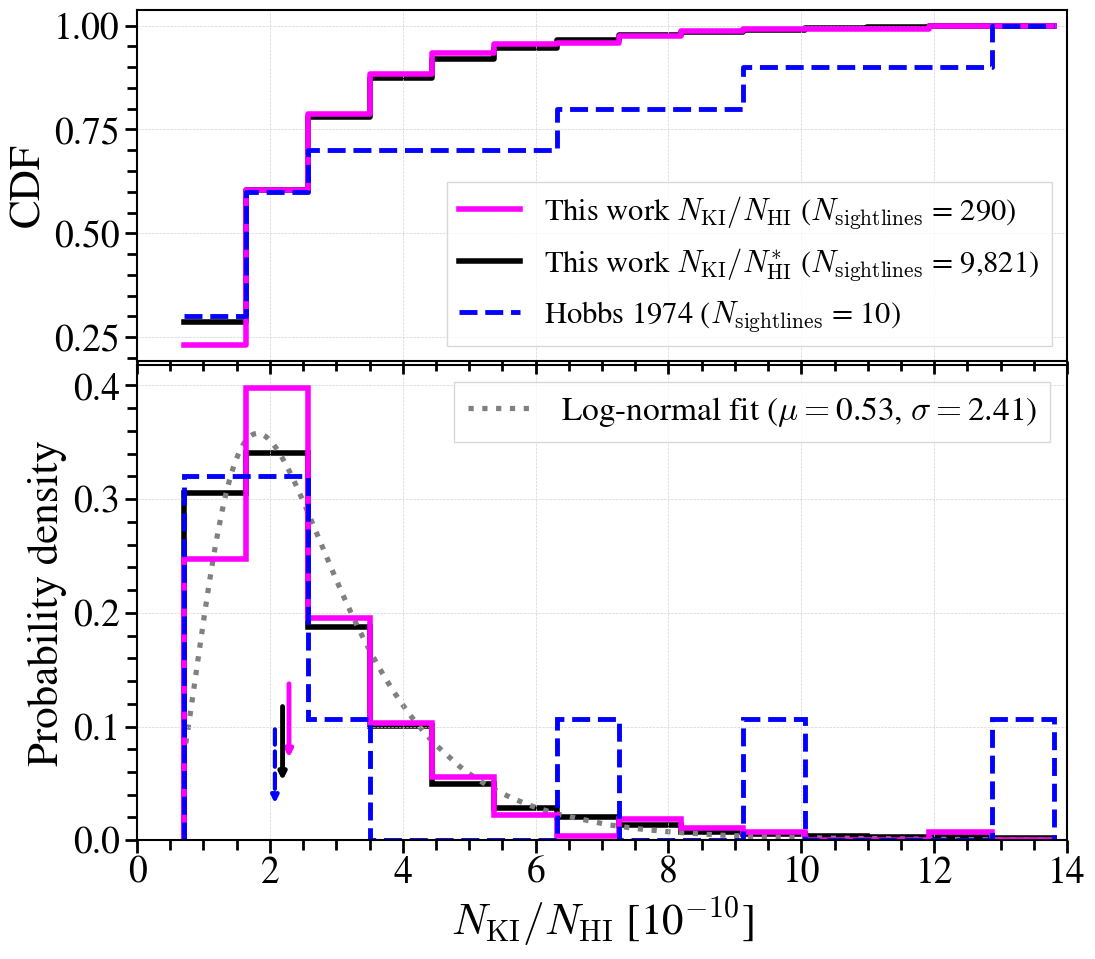

In [ ]:
import matplotlib.gridspec as gridspec
mpl.rcParams['axes.linewidth'] = 1.5



lw = 3.
binx = [10, 16, 9, 10, 5, 3]
linesty = '--'
colors = ['k', 'k', 'deepskyblue', 'gray', 'black', 'skyblue']
survey_labels = ['21-SPONGE (M15)', 'Millennium Survey (HT03)', 'Perseus (S14)', 'GMRT04', 'GNOMES', 'MACH']


xylabel = 31
xytlabel = 27


# Figure
fig = plt.figure(figsize=(12,11))
gs = gridspec.GridSpec(7, 10)
ax = plt.subplot(gs[3:7, 0:10])
ax_cdf = plt.subplot(gs[0:3, 0:10],sharex=ax)


ploti, = ax.plot([], [], 'k-', lw=lw+0.5, label='')
ploti.set_visible(True)



mainline_color = 'k'
cnts, bins, _ = ax.hist(x_gg, bins=np.linspace(0.7, 13.8, 15),
         density=True, color='magenta', histtype='step',
         alpha=1., ls='-', linewidth=lw+1,
         label='')

cnts1, bins1, _ = ax.hist(x_hobbs, bins=np.linspace(0.7, 13.8, 15),
         density=True, color='b', histtype='step',
         alpha=1., linestyle='--', linewidth=lw+0.5,
         label='')


color = 'magenta'
cnts2, bins2, _ = ax.hist(ki_hi_ratio, bins=np.linspace(0.7, 13.8, 15),
         density=True, color='k', histtype='step', zorder=-2,
         alpha=1., linestyle='-', linewidth=lw+1.,
         label='')

ploti, = ax.plot([], [], color=color, linestyle='--', linewidth=lw+1., label='')
ploti.set_visible(True)

ax.plot(np.sort(x_all), lognorm_pdf, color='gray', linestyle=':', lw=lw+0.75, zorder=-2, label=f'Log-normal fit ($\mu = ${lognorm_params[0]:.2f}, $\sigma = ${lognorm_params[2]:.2f})')



## Arrows for medians
gg_med_val = np.median(x_gg)
gg_med_val_thin = np.median(ki_hi_ratio)
hobbs_med_val = np.median(x_hobbs)


ax.annotate('', xy=(gg_med_val, 0.07), xycoords='data', xytext=(gg_med_val, 0.14), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color='magenta', lw=3.5, ls='-'))

ax.annotate('', xy=(gg_med_val_thin, 0.05), xycoords='data', xytext=(gg_med_val_thin, 0.12), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color='k', lw=3.5, ls='-'))

ax.annotate('', xy=(hobbs_med_val, 0.03), xycoords='data', xytext=(hobbs_med_val, 0.1), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color='b', lw=3., ls='--'))



ax.set_xlabel(r'$N_\mathrm{KI} / N_\mathrm{HI}$ [10$^{-10}$]', fontsize=xylabel)
ax.set_ylabel(r'Probability density', fontsize=xylabel)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=xytlabel, pad=2)
ax.tick_params(axis='y', labelsize=xytlabel)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=7)



ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax.legend(loc='upper right', fancybox=False, framealpha=0.75, labelcolor='k', fontsize=24)







# Top
cdf = np.cumsum(cnts)/np.sum(cnts)
ax_cdf.set_ylabel('CDF', fontsize=xylabel)

ax_cdf.plot(
    np.vstack((bins, np.roll(bins, -1))).T.flatten()[:-2],
    np.vstack((cdf, cdf)).T.flatten(),
    color='magenta', ls='-', lw=lw+1,
    alpha=0.99, label=r'This work $N_\mathrm{KI} / N_\mathrm{HI}$ ($N_\mathrm{sightlines}$ = 290)',
)



cdf2 = np.cumsum(cnts2)/np.sum(cnts2)

ax_cdf.plot(
    np.vstack((bins2, np.roll(bins2, -1))).T.flatten()[:-2],
    np.vstack((cdf2, cdf2)).T.flatten(),
    color='k', ls='-', lw=lw+1., zorder=-2,
    alpha=0.99, label=r'This work $N_\mathrm{KI} / N^{*}_\mathrm{HI}$ ($N_\mathrm{sightlines}$ = 9,821)',
)




# ax
cdf3 = np.cumsum(cnts1)/np.sum(cnts1)

ax_cdf.plot(
    np.vstack((bins1, np.roll(bins1, -1))).T.flatten()[:-2],
    np.vstack((cdf3, cdf3)).T.flatten(),
    color='b', ls=linesty, lw=lw+0.5,
    alpha=0.99, label=r'Hobbs 1974 ($N_\mathrm{sightlines}$ = 10)'
)



ax_cdf.minorticks_on()
ax_cdf.tick_params(axis='x', labelsize=xytlabel, pad=2)
ax_cdf.tick_params(axis='y', labelsize=xytlabel)
ax_cdf.tick_params(which='both', width=2)
ax_cdf.tick_params(which='major', length=9)
ax_cdf.tick_params(which='minor', length=7)



ax_cdf.set_xlim(0.,14.)

ax_cdf.tick_params('y', colors='k')
ax_cdf.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
plt.setp(ax_cdf.get_xticklabels(), visible=False)

ax_cdf.legend(loc='lower right', fancybox=False, framealpha=0.75, labelcolor='k', fontsize=22)


# Adjust the position of the second panel
pos2 = ax.get_position()
ax.set_position([pos2.x0, pos2.y0 + 0.015, pos2.width, pos2.height])


plt.show()

In [ ]:
print('Ki abundance ratio: NKI/NHI_thin', gg_med_val_thin)

Ki abundance ratio: NKI/NHI_thin 2.190110063493378


# End